In [46]:
# import libraries
import pandas as pd
import xgboost as xgb
import numpy as np

pd.set_option('display.max_columns', None)

In [47]:
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/final.csv')

In [48]:
data.shape

(23528, 205)

In [49]:
# isolate x and y variables
X = data.drop(columns='outcome')
y = data.outcome

In [50]:
y.value_counts()

outcome
0.0    23139
1.0      389
Name: count, dtype: int64

In [51]:
# split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [52]:
# show target mean

display(np.mean(y_train))
display(np.mean(y_test))


0.01578723662638897

0.01827454313642159

In [53]:
# create xgboost matrix
train = xgb.DMatrix(X_train, label = y_train)
test = xgb.DMatrix(X_test, label = y_test)

In [54]:
# set the parameters for xgboost
parameters1 = {'learning_rate':0.3,
                'max_depth': 2,
                'colsample_bytree': 1,
                'subsample': 1,
                'min_child_weight': 1,
                'gamma': 0,
                'random_state': 1502,
                'eval_metric': 'auc',
                'objective': 'binary:logistic'}


In [55]:
# run XGBoost
model = xgb.train(params=parameters1,
                  dtrain=train,
                  num_boost_round=200,
                  evals = [(test, 'yes')],
                  verbose_eval=50)
                  

[0]	yes-auc:0.99600
[50]	yes-auc:0.99749
[100]	yes-auc:0.99738
[150]	yes-auc:0.99731
[199]	yes-auc:0.99734


In [56]:
# predictions
predictions1 = model.predict(test)
predictions1 = np.where(predictions1 > 0.5, 1, 0)

In [57]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

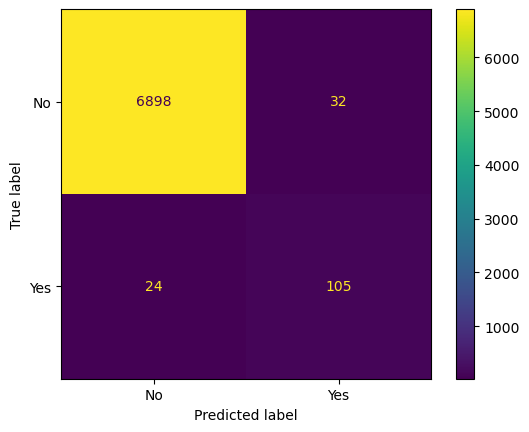

In [58]:
# show confusion matrix display
confusion_matrix1 = confusion_matrix(y_test, predictions1)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix1, display_labels=['No', 'Yes'])
disp.plot();

In [59]:
report1 = classification_report(y_test, predictions1)
print(report1)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6930
         1.0       0.77      0.81      0.79       129

    accuracy                           0.99      7059
   macro avg       0.88      0.90      0.89      7059
weighted avg       0.99      0.99      0.99      7059



In [60]:
feature_columns = list(data.columns)
# remove outcome column
feature_columns.remove('outcome')

In [61]:
# isolate x and y variables part 2
X = data.drop(columns='outcome')
y = data.outcome 

In [62]:
# split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [63]:
# create xgboost matrix
train = xgb.DMatrix(X_train, label = y_train, feature_names = feature_columns)
test = xgb.DMatrix(X_test, label = y_test, feature_names = feature_columns)

In [64]:
# set the parameters for xgboost part 2
parameters2 = {'learning_rate':0.3,
                'max_depth': 2,
                'colsample_bytree': 1,
                'subsample': 1,
                'min_child_weight': 1,
                'gamma': 0,
                'random_state': 1502,
                'eval_metric': 'auc',
                'objective': 'binary:logistic'}


In [65]:
# run XGBoost
model2 = xgb.train(params=parameters2,
                  dtrain=train,
                  num_boost_round=200,
                  evals = [(test, 'yes')],
                  verbose_eval=50)
                  

[0]	yes-auc:0.99570
[50]	yes-auc:0.99689
[100]	yes-auc:0.99691
[150]	yes-auc:0.99689
[199]	yes-auc:0.99685


In [66]:
# predictions
predictions2 = model2.predict(test)
predictions2 = np.where(predictions2 > 0.5, 1, 0)

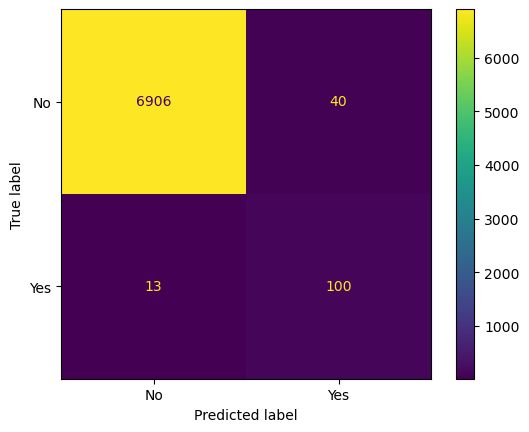

In [67]:
# show confusion matrix display
confusion_matrix2 = confusion_matrix(y_test, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix2, display_labels=['No', 'Yes'])
disp.plot();

In [68]:
report2 = classification_report(y_test, predictions2)
print(report2)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      6946
         1.0       0.71      0.88      0.79       113

    accuracy                           0.99      7059
   macro avg       0.86      0.94      0.89      7059
weighted avg       0.99      0.99      0.99      7059



In [94]:
# setting the cross validation parameters
from sklearn.model_selection import KFold

tune_control = KFold(n_splits=5, shuffle=True, random_state=1502).split(X = X_train, y = y_train)

In [95]:
# set parameter tuning
tune_grid = {'learning_rate':[0.05,0.3],
                'max_depth':range(2,9,2),
                'colsample_bytree': [0.5,1],
                'subsample': [1],
                'min_child_weight':[1],
                'gamma': [0],
                'random_state': [1502],
                'n_estimators':range(200, 2000, 200),
                'booster':['gbtree']
                }

In [96]:
# state we are doing a classification problem
from xgboost import XGBClassifier
classifier = XGBClassifier(objective='binary:logistic')

In [97]:
# cross validation assembly
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = classifier,  
                            param_grid = tune_grid, 
                            scoring = 'roc_auc',
                            n_jobs = 8,
                            cv = tune_control,
                            verbose = 5)

In [98]:
# setting evaluation parameters
evaluation_parameters = {'early_stopping_rounds':100,
                        'eval_metric':'auc',
                        'eval_set':[(X_test, y_test)]}  

In [ ]:
# hyperparameter tuning and cross validation
tune_model = grid_search.fit(X=X_train, y=y_train, **evaluation_parameters)



In [100]:
grid_search.best_params_, grid_search.best_score_

({'booster': 'gbtree',
  'colsample_bytree': 0.5,
  'gamma': 0,
  'learning_rate': 0.05,
  'max_depth': 4,
  'min_child_weight': 1,
  'n_estimators': 200,
  'random_state': 1502,
  'subsample': 1},
 0.9973965373975504)

In [104]:
# predictions
predictions3 = model2.predict(test)
predictions3 = np.where(predictions3 > 0.5, 1, 0)

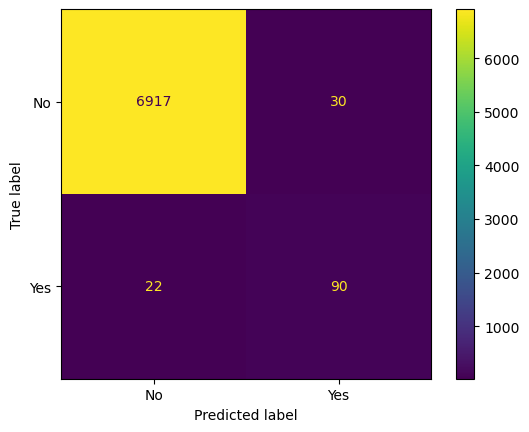

In [105]:
# show confusion matrix display
confusion_matrix3 = confusion_matrix(y_test, predictions3)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix3, display_labels=['No', 'Yes'])
disp.plot();

In [69]:
parameters3 = {'learning_rate':0.05,
                'max_depth': 4,
                'colsample_bytree':0.5,
                'subsample': 1,
                'min_child_weight': 2,
                'gamma': 0,
                'eval_metric': 'auc',
                'objective': 'binary:logistic'}

In [70]:
# run XGBoost 3
model3 = xgb.train(params=parameters3,
                  dtrain=train,
                  num_boost_round=800,
                  evals = [(test, 'yes')],
                  verbose_eval=50)

[0]	yes-auc:0.76854
[50]	yes-auc:0.99712
[100]	yes-auc:0.99701
[150]	yes-auc:0.99696
[200]	yes-auc:0.99700
[250]	yes-auc:0.99705
[300]	yes-auc:0.99705
[350]	yes-auc:0.99704
[400]	yes-auc:0.99705
[450]	yes-auc:0.99709
[500]	yes-auc:0.99708
[550]	yes-auc:0.99712
[600]	yes-auc:0.99714
[650]	yes-auc:0.99712
[700]	yes-auc:0.99714
[750]	yes-auc:0.99716
[799]	yes-auc:0.99715


In [71]:
# predictions
predictions3 = model3.predict(test)
predictions3 = np.where(predictions3 > 0.05, 1, 0)

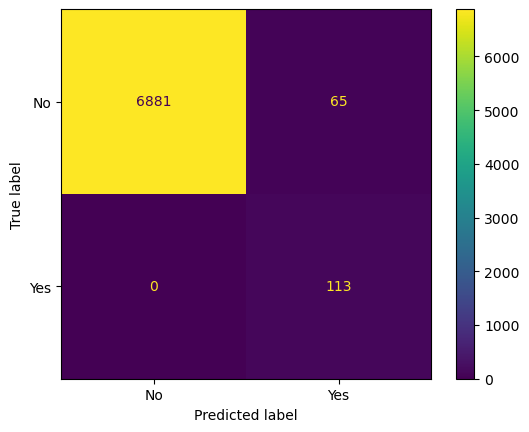

In [72]:
# show confusion matrix display
confusion_matrix3 = confusion_matrix(y_test, predictions3)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix3, display_labels=['No', 'Yes'])
disp.plot();

In [73]:
report3 = classification_report(y_test, predictions3)
print(report3)

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      6946
         1.0       0.63      1.00      0.78       113

    accuracy                           0.99      7059
   macro avg       0.82      1.00      0.89      7059
weighted avg       0.99      0.99      0.99      7059



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

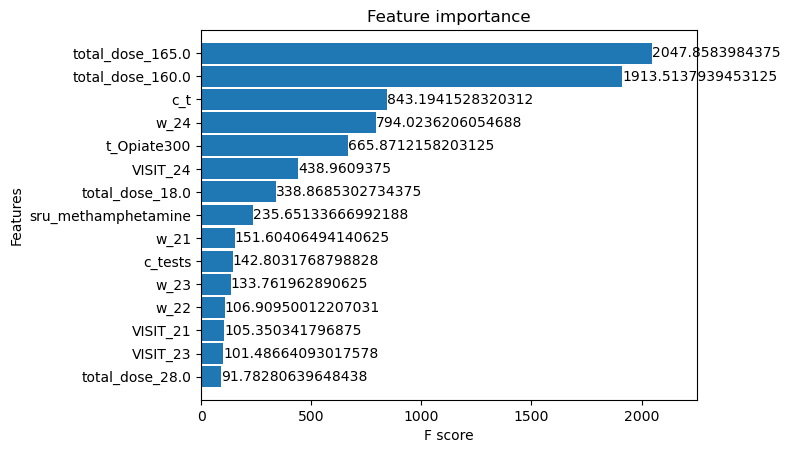

In [82]:
# plot importances

xgb.plot_importance(model3, max_num_features=15, height=.9, importance_type='cover', grid=False)

In [87]:
# preparing shap
import shap

explainer = shap.TreeExplainer(model3)
shap_values = explainer.shap_values(X_test)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


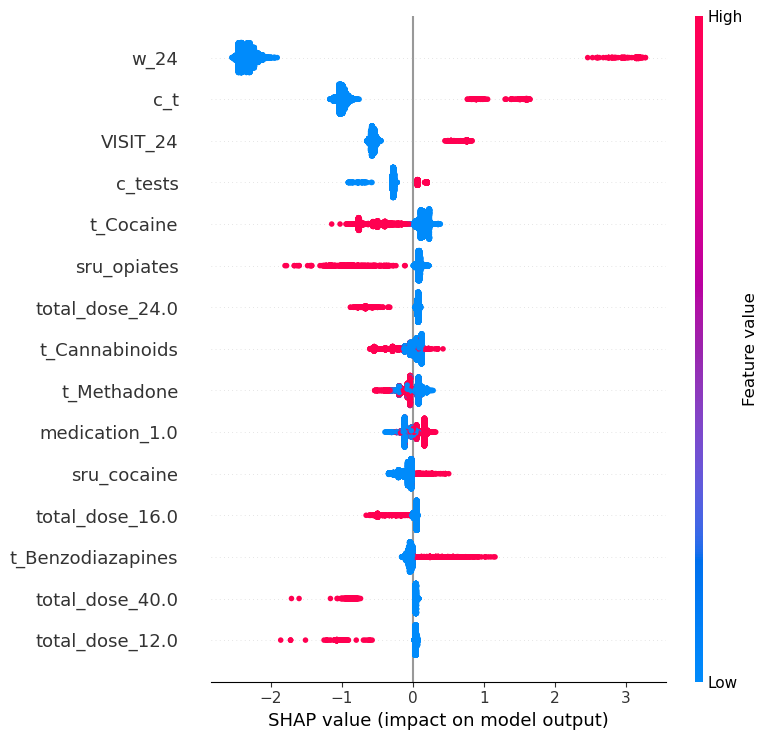

In [88]:
#shap plotting

shap.summary_plot(shap_values,
                  X_test,
                  feature_names = feature_columns,
                  max_display=15);

In [89]:
# save model
model3.save_model('xgboost_classifier.model')

# save predictions
predictions3 = pd.DataFrame(predictions3)
predictions3.to_csv('xgboost_classifier_predictions.csv')

# save feature importance
feature_importance = pd.DataFrame(model3.get_score(importance_type='cover'), index=[0]).T
feature_importance.to_csv('xgboost_classifier_feature_importance.csv')

# save shap values
shap_values = pd.DataFrame(shap_values)
shap_values.to_csv('xgboost_classifier_shap_values.csv')


